# Overview

The purpose of this project is to be able to classify the image of a given product into any of the below mentioned categories:

- 61326_ok_front
- 61326_ok_back
- 61326_wrinkle
- 61326_thinning
- 61326_slot_damage
- 61326_scratch_mark

For this we have been provided the training data as well as the test data in respective directories.

Here, we will train a Convolutional Neural Network for this purpose and the development process will include below steps:

1. Defining Necessary Imports and Basic Configs
2. Create Training Data
3. Create Model
4. Train Model
5. Use Model

## 1. Defining Necessary Imports and Basic Configs

In [17]:
import cv2                 # Working with, mainly resizing, images
import numpy as np         
import os                  
from random import shuffle 
from tqdm import tqdm      # A nice pretty percentage bar for tasks.
import re
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import matplotlib.pyplot as plt
%matplotlib inline

pat=re.compile(r'[^a-z ]') # for extracting valid class labels from directory names

TRAIN_DIR = './data/All_61326/train_61326'
TEST_DIR = './data/All_61326/test_61326'
IMG_SIZE = 250            # Image size to be used
LR = 1e-3                 # Learning Rate of the algorithm
batch_size=64             # Batch Size
f1=5                      # Filter Size for first Conv Layer
n_f1=32                   # Number of filters in the first Conv Layer
f2=5                      # Filter Size for second Conv Layer
n_f2=64                   # Number of filters in the second Conv Layer
pool_1=5                  # Kernel size for pooling layer 1
pool_2=5                  # Kernel size for pooling layer 2
fc_units=1024             # Number of units in fully connected layer
keep_prob=0.8             # Keep_Prob for the dropout layer
num_classes=6             # Number of classes

MODEL_NAME = 'img_classifier-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which

class_labels=[
'61326_ok_front',
'61326_ok_back',
'61326_wrinkle',
'61326_thinning',
'61326_slot_damage',
'61326_scratch_mark',
]

## 2. Create Training Data

In [12]:
def label_img(lbl):
    '''
    Class Labels:
    [ok_front, ok_back, wrinkle, thinning, slot_damage, scratch_mark]
    
    Arguments:
    lbl - label name or the directory name
    
    Returns:
    One-hot encoded vector corresponding to the label
    '''
    
    lbl=lbl.lower()
    word_label = '_'.join(pat.sub(' ',lbl).split())
    
    # conversion to one-hot array [ok_front, ok_back, wrinkle, thinning, slot_damage, scratch_mark]
    if word_label == 'ok_front': return [1, 0, 0, 0, 0, 0]
    elif word_label == 'ok_back': return [0, 1, 0, 0, 0, 0]
    elif word_label == 'wrinkle': return [0, 0, 1, 0, 0, 0]
    elif word_label == 'thinning': return [0, 0, 0, 1, 0, 0]
    elif word_label == 'slot_damage': return [0, 0, 0, 0, 1, 0]
    elif word_label == 'scratch_mark': return [0, 0, 0, 0, 0, 1]
    
def create_train_data():
    training_data = []
    for folder,_,images in tqdm(os.walk(TRAIN_DIR)):
        if len(images)<3: continue
        dir_name=os.path.basename(folder)
        label = label_img(dir_name)
        for img in images:
            if not img.endswith('.jpg'): continue
            path = os.path.join(folder,img)
            img = cv2.imread(path
                             ,cv2.IMREAD_GRAYSCALE
                            )
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

training_data=create_train_data()
X = np.array([i[0] for i in training_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = np.array([i[1] for i in training_data])

# Normalize the input data
X=X/255.

print('Length of training data:',len(training_data))
print("Shape of X {}, Shape of Y {}".format(X.shape,Y.shape))

7it [00:18,  2.58s/it]

Length of training data: 217
Shape of X (217, 250, 250, 1), Shape of Y (217, 6)


## 3. Create Model

In [13]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, n_f1, f1, activation='relu')
convnet = max_pool_2d(convnet, pool_1)
convnet = conv_2d(convnet, n_f2, f2, activation='relu')
convnet = max_pool_2d(convnet, pool_2)
convnet = fully_connected(convnet, n_units=fc_units, activation='relu')
convnet = dropout(convnet, keep_prob=keep_prob)
convnet = fully_connected(convnet, num_classes, activation='softmax')
convnet = regression(convnet, optimizer='adam', 
                     learning_rate=LR,
                     batch_size=batch_size,
                     loss='categorical_crossentropy',
                     name='targets')
model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


#### Load saved model if exists

In [14]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from /Users/atulsharma/study_datascience/tensorflow/jbm/img_classifier-0.001-2conv-basic.model
model loaded!


## 4. Train Model

** Approaches ~ 98% Accuracy in 30 epochs **

In [137]:
model.fit({'input': X}, {'targets': Y}, n_epoch=30, 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 119  | total loss: 0.05842 | time: 4.979s
| Adam | epoch: 030 | loss: 0.05842 - acc: 0.9827 -- iter: 192/217
Training Step: 120  | total loss: 0.05905 | time: 5.815s
| Adam | epoch: 030 | loss: 0.05905 - acc: 0.9804 -- iter: 217/217
--


#### Save model

In [138]:
model.save(MODEL_NAME)

INFO:tensorflow:/Users/atulsharma/study_datascience/tensorflow/jbm/img_classifier-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


## 5. Use Model

    - bulk_predict     : predicts all the images in bulk mode in provided directory
    - predict          : predicts label for given image
    - predict_on_train : make predictions on training set

In [22]:
def bulk_predict(test_dir,show_image=True):
    for img in os.listdir(test_dir):
        print("Current Image Name:",img)
        path=os.path.join(test_dir,img)
        img = cv2.imread(path
                         ,cv2.IMREAD_GRAYSCALE
                        )
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        img = np.array(img).reshape(-1,IMG_SIZE,IMG_SIZE,1)
        if show_image:
            plt.imshow(img[0].squeeze(),cmap='gray')
            plt.show()
        #normalize
        img=img/255.
        pred_id=np.argmax(model.predict(img),1)[0]
        print("Predicted Label:",class_labels[pred_id])
        print("#"*50)
        
        
def predict(path,show_image=True):
    print("Current Image Name:",path)
    img = cv2.imread(path
                     ,cv2.IMREAD_GRAYSCALE
                    )
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    img = np.array(img).reshape(-1,IMG_SIZE,IMG_SIZE,1)
    if show_image:
        plt.imshow(img[0].squeeze(),cmap='gray')
        plt.show()
    #normalize
    img=img/255.
    pred_id=np.argmax(model.predict(img),1)[0]
    print("Predicted Label:",class_labels[pred_id])
    print("#"*50)
    
def predict_on_train(idx=0):
    pred_id=np.argmax(model.predict(X[idx].reshape(1,IMG_SIZE,IMG_SIZE,1)),1)[0]
    print('predicted correctly :',pred_id==np.argmax(Y[idx]))
    print('prediction          :',class_labels[pred_id])
    plt.imshow(X[idx].squeeze(),cmap="gray")
        

Current Image Name: ./data/All_61326/test_61326/61326-TH- (39).jpg


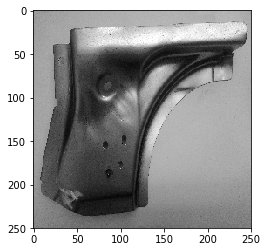

Predicted Label: 61326_thinning
##################################################


In [23]:
predict(r'./data/All_61326/test_61326/61326-TH- (39).jpg',show_image=True) 

Current Image Name: 61326-TH- (39).jpg


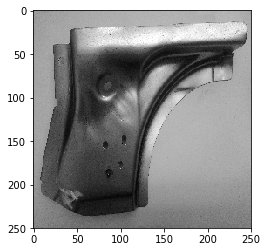

Predicted Label: 61326_thinning
##################################################
Current Image Name: 61326 (Front Side)-OK- (87).jpg


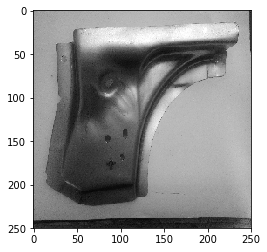

Predicted Label: 61326_ok_front
##################################################
Current Image Name: 61326 (Back Side) -OK- (40).jpg


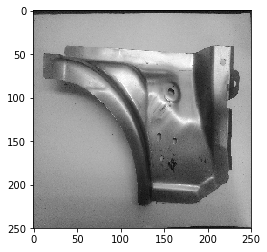

Predicted Label: 61326_ok_back
##################################################
Current Image Name: 61326-SC-(20).jpg


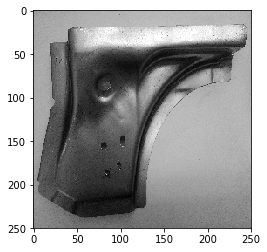

Predicted Label: 61326_thinning
##################################################
Current Image Name: 61326-WR- (20).jpg


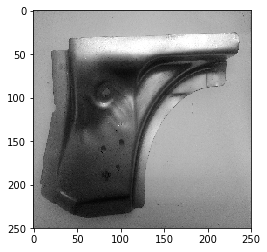

Predicted Label: 61326_wrinkle
##################################################
Current Image Name: 61326-SD- (17).jpg


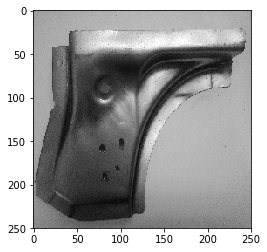

Predicted Label: 61326_slot_damage
##################################################


In [24]:
bulk_predict(TEST_DIR)

predicted correctly : True
prediction          : 61326_ok_front


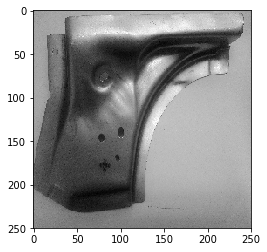

In [26]:
predict_on_train(50)